In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import os
import glob
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
from rasterio.plot import show
import rioxarray as rio
import xarray as xr
from pyproj import Proj, transform
import sys
import subprocess
sys.path.insert(1, 'Tools')
from dea_tools.plotting import display_map

In [3]:
output_path = pathlib.Path("/home/jovyan/datastorage/model_output/Output_7.nc")

In [4]:
ds = xr.open_dataset(output_path)
ds

<xarray.Dataset>
Dimensions:      (time: 43, blockid: 2091, xx_P0: 656, yy_P0: 816)
Coordinates:
  * time         (time) float32 9.969e+36 600.0 1.2e+03 ... 2.46e+04 2.52e+04
  * blockid      (blockid) int32 0 1 2 3 4 5 6 ... 2085 2086 2087 2088 2089 2090
  * xx_P0        (xx_P0) float64 1.571e+06 1.571e+06 ... 1.577e+06 1.577e+06
  * yy_P0        (yy_P0) float64 5.192e+06 5.192e+06 ... 5.2e+06 5.2e+06
Data variables:
    blockxo      (blockid) float32 ...
    blockyo      (blockid) float32 ...
    blockwidth   (blockid) float32 ...
    blocklevel   (blockid) int32 ...
    blockstatus  (blockid) int32 ...
    h_P0         (time, yy_P0, xx_P0) float32 ...
    u_P0         (time, yy_P0, xx_P0) float32 ...
    v_P0         (time, yy_P0, xx_P0) float32 ...
    zs_P0        (time, yy_P0, xx_P0) float32 ...
    hmax_P0      (time, yy_P0, xx_P0) float32 ...
    zb_P0        (time, yy_P0, xx_P0) float32 ...
Attributes:
    maxlevel:  0
    minlevel:  0
    xmin:      1570595.0
    xmax:      1577155.0
    ymin:      5191995.0
    ymax:      5200155.0

In [5]:
x_min, x_max, y_min, y_max = (1570595.0, 1577155.0, 5191995.0, 5200155.0)
x = (x_min, x_max)
y = (y_min, y_max)
crs = 'EPSG:2193'
y, x = transform(Proj(crs), Proj('EPSG:4326'), y, x)
print(y, x)
display_map(x=x, y=y, margin=-0.8)

(-43.42435924021607, -43.351112315334454) (172.63672959374335, 172.71811165663996)


In [6]:
ds = ds.drop(['blockid', 'blockxo', 'blockyo', 'blockwidth', 'blocklevel', 'blockstatus'])
ds = ds.rename({'xx_P0':'x', 'yy_P0':'y'})

output_path = pathlib.Path("/home/jovyan/datastorage/model_output/Output_8.nc")

ds.to_netcdf(output_path)

In [7]:
ds = xr.open_dataset(output_path)
ds

<xarray.Dataset>
Dimensions:  (time: 43, x: 656, y: 816)
Coordinates:
  * time     (time) float32 9.969e+36 600.0 1.2e+03 ... 2.46e+04 2.52e+04
  * x        (x) float64 1.571e+06 1.571e+06 1.571e+06 ... 1.577e+06 1.577e+06
  * y        (y) float64 5.192e+06 5.192e+06 5.192e+06 ... 5.2e+06 5.2e+06
Data variables:
    h_P0     (time, y, x) float32 ...
    u_P0     (time, y, x) float32 ...
    v_P0     (time, y, x) float32 ...
    zs_P0    (time, y, x) float32 ...
    hmax_P0  (time, y, x) float32 ...
    zb_P0    (time, y, x) float32 ...
Attributes:
    maxlevel:  0
    minlevel:  0
    xmin:      1570595.0
    xmax:      1577155.0
    ymin:      5191995.0
    ymax:      5200155.0

In [8]:
ds_h = ds['h_P0']
ds_h

<xarray.DataArray 'h_P0' (time: 43, y: 816, x: 656)>
[23017728 values with dtype=float32]
Coordinates:
  * time     (time) float32 9.969e+36 600.0 1.2e+03 ... 2.46e+04 2.52e+04
  * x        (x) float64 1.571e+06 1.571e+06 1.571e+06 ... 1.577e+06 1.577e+06
  * y        (y) float64 5.192e+06 5.192e+06 5.192e+06 ... 5.2e+06 5.2e+06
Attributes:
    missingvalue:  9.9692e+36

In [9]:
ds_h = ds_h.rio.set_spatial_dims(x_dim='x', y_dim='y')
ds_h.rio.crs
ds_h.rio.write_crs("epsg:4326", inplace=True)
ds_h.rio.resolution()

(10.0, 10.0)

In [10]:
base_path = os.path.dirname(output_path)

i = 0
print(pathlib.Path(f"{base_path}/datasets/dt_{i}.tif"))

_ = [ds_h.isel(time=i).rio.to_raster(pathlib.Path(f"{base_path}/datasets/dt_{i}.tif")) for i in range(0, 43)]

/home/jovyan/datastorage/model_output/datasets/dt_0.tif


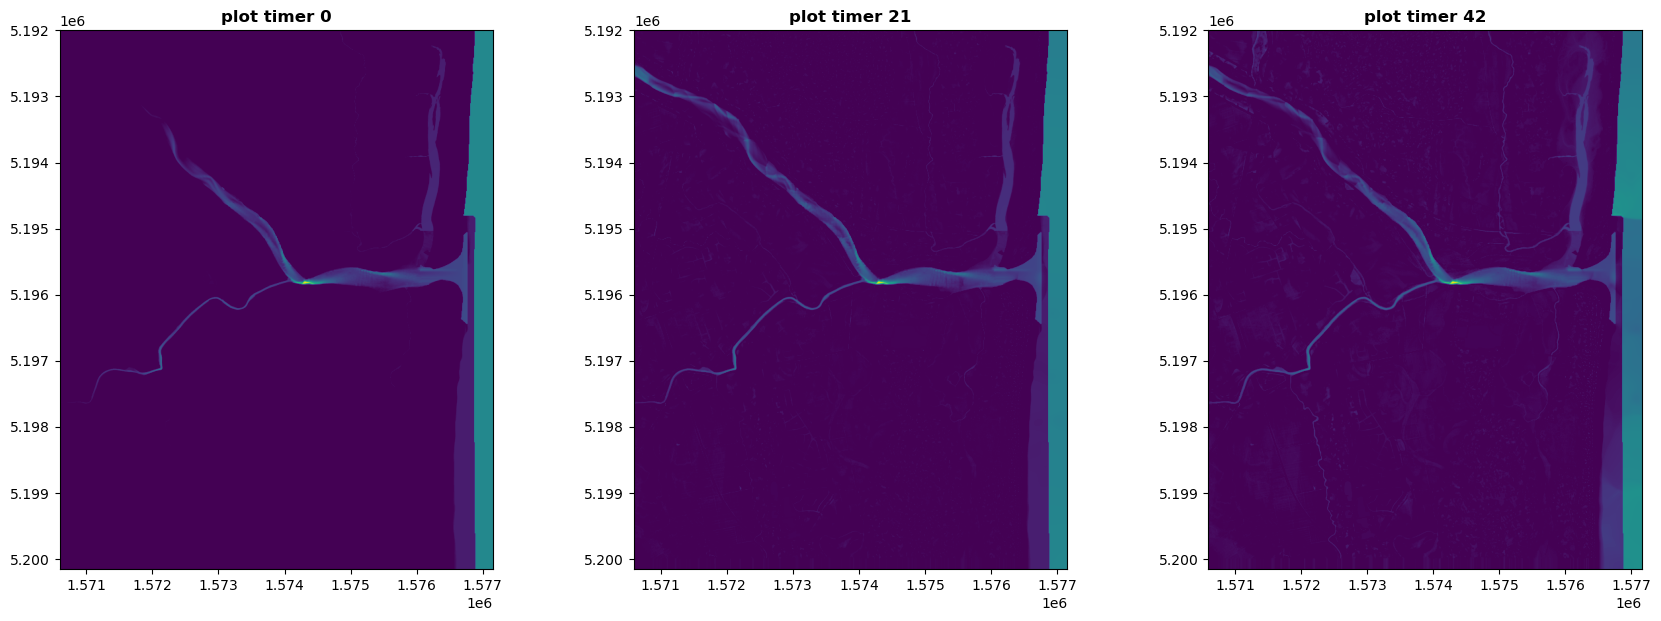

In [11]:
fig, axs = plt.subplots(1,3, figsize=(21,7))
timer = [0, 21, 42]
for i, t in enumerate(timer):
    show(rasterio.open(f'{base_path}/datasets/dt_{t}.tif'), ax=axs[i], title=f'plot timer {t}')
plt.show()

In [13]:
from eodatasets3 import DatasetAssembler
from datetime import datetime, timedelta

collection = pathlib.Path(f"{base_path}/assemble/")

for i in range(0, 43):
#i = 0
    with DatasetAssembler(collection, naming_conventions='default') as p:
        p.product_family = "dt_flood"
        # Date of acquisition (UTC if no timezone).
        p.datetime = datetime(2019, 7, 4, 13, 7, 5) + timedelta(days=i)
        # When the data was processed/created.
        p.processed_now() # Right now!
        # (If not newly created, set the date on the field: `p.processed = ...`)
        # Write our measurement from the given path, calling it 'blue'.
        p.write_measurement("h", f'{base_path}/datasets/dt_{i}.tif')
        # Complete the dataset.
        p.done()

In [14]:
dataset_list = []
for path in collection.glob("**/*.odc-metadata.yaml"):
    dataset_list.append(path)
    print(dataset_list[-1])

/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/04/dt_flood_2019-07-04.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/05/dt_flood_2019-07-05.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/06/dt_flood_2019-07-06.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/07/dt_flood_2019-07-07.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/08/dt_flood_2019-07-08.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/09/dt_flood_2019-07-09.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/10/dt_flood_2019-07-10.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/11/dt_flood_2019-07-11.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/12/dt_flood_2019-07-12.odc-metadata.yaml
/home/jovyan/datastorage/model_output/assemble/dt_flood

In [16]:
! datacube product add dt_flood.odc-product.yaml

Adding "dt_flood" (this might take a while) DONE


In [17]:
for i in range(0, len(dataset_list)):
    dataset = dataset_list[i]
    print(subprocess.run(f'datacube dataset add {dataset}', shell=True, check=True))

CompletedProcess(args='datacube dataset add /home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/04/dt_flood_2019-07-04.odc-metadata.yaml', returncode=0)
CompletedProcess(args='datacube dataset add /home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/05/dt_flood_2019-07-05.odc-metadata.yaml', returncode=0)
CompletedProcess(args='datacube dataset add /home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/06/dt_flood_2019-07-06.odc-metadata.yaml', returncode=0)
CompletedProcess(args='datacube dataset add /home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/07/dt_flood_2019-07-07.odc-metadata.yaml', returncode=0)
CompletedProcess(args='datacube dataset add /home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/08/dt_flood_2019-07-08.odc-metadata.yaml', returncode=0)
CompletedProcess(args='datacube dataset add /home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/09/dt_flood_2019-07-09.odc-metadata.yaml', returncode=0)
CompletedP

In [18]:
import datacube

dc = datacube.Datacube(app="ingestion")

dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
dt_flood,dt_flood,Digital Twins Flood,CC-BY-4.0,None,None
ga_ls8c_ard_3,ga_ls8c_ard_3,Geoscience Australia Landsat 8 Operational Lan...,CC-BY-4.0,None,None
ga_s2am_ard_3,ga_s2am_ard_3,Geoscience Australia Sentinel 2A MSI Analysis ...,CC-BY-4.0,None,None


In [19]:
dc.list_measurements()

name    dtype  \
product       measurement                                                       
dt_flood      h                                                    h  float32   
ga_ls8c_ard_3 nbart_coastal_aerosol            nbart_coastal_aerosol    int16   
              nbart_blue                                  nbart_blue    int16   
              nbart_green                                nbart_green    int16   
              nbart_red                                    nbart_red    int16   
              nbart_nir                                    nbart_nir    int16   
              nbart_swir_1                              nbart_swir_1    int16   
              nbart_swir_2                              nbart_swir_2    int16   
              nbart_panchromatic                  nbart_panchromatic    int16   
              oa_fmask                                      oa_fmask    uint8   
              oa_nbart_contiguity                oa_nbart_contiguity    uint8   
              oa_azimuthal_exiting              oa_azimuthal_exiting  float32   
              oa_azimuthal_incident            oa_azimuthal_incident  float32   
              oa_combined_terrain_shadow  oa_combined_terrain_shadow    uint8   
              oa_exiting_angle                      oa_exiting_angle  float32   
              oa_incident_angle                    oa_incident_angle  float32   
              oa_relative_azimuth                oa_relative_azimuth  float32   
              oa_relative_slope                    oa_relative_slope  float32   
              oa_satellite_azimuth              oa_satellite_azimuth  float32   
              oa_satellite_view                    oa_satellite_view  float32   
              oa_solar_azimuth                      oa_solar_azimuth  float32   
              oa_solar_zenith                        oa_solar_zenith  float32   
              oa_time_delta                            oa_time_delta  float32   
ga_s2am_ard_3 nbart_coastal_aerosol            nbart_coastal_aerosol    int16   
              nbart_blue                                  nbart_blue    int16   
              nbart_green                                nbart_green    int16   
              nbart_red                                    nbart_red    int16   
              nbart_red_edge_1                      nbart_red_edge_1    int16   
              nbart_red_edge_2                      nbart_red_edge_2    int16   
              nbart_red_edge_3                      nbart_red_edge_3    int16   
              nbart_nir_1                                nbart_nir_1    int16   
              nbart_nir_2                                nbart_nir_2    int16   
              nbart_swir_2                              nbart_swir_2    int16   
              nbart_swir_3                              nbart_swir_3    int16   
              oa_fmask                                      oa_fmask    uint8   
              oa_nbart_contiguity                oa_nbart_contiguity    uint8   
              oa_azimuthal_exiting              oa_azimuthal_exiting  float32   
              oa_azimuthal_incident            oa_azimuthal_incident  float32   
              oa_combined_terrain_shadow  oa_combined_terrain_shadow    uint8   
              oa_exiting_angle                      oa_exiting_angle  float32   
              oa_incident_angle                    oa_incident_angle  float32   
              oa_relative_azimuth                oa_relative_azimuth  float32   
              oa_relative_slope                    oa_relative_slope  float32   
              oa_satellite_azimuth              oa_satellite_azimuth  float32   
              oa_satellite_view                    oa_satellite_view  float32   
              oa_solar_azimuth                      oa_solar_azimuth  float32   
              oa_solar_zenith                        oa_solar_zenith  float32   
              oa_time_delta                            oa_time_delta  float32   
              

In [20]:
ds = dc.find_datasets(product="dt_flood")
ds

[Dataset <id=8e7655b9-21fc-4ec0-a53c-28d22b19a29a product=dt_flood location=file:///home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/04/dt_flood_2019-07-04.odc-metadata.yaml>,
 Dataset <id=fd13ab68-981e-454e-a27a-566b1983831e product=dt_flood location=file:///home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/05/dt_flood_2019-07-05.odc-metadata.yaml>,
 Dataset <id=5d44d659-ee3a-4405-b8f8-9e31c08c367e product=dt_flood location=file:///home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/06/dt_flood_2019-07-06.odc-metadata.yaml>,
 Dataset <id=0e8374e1-a7da-42f3-85ef-2ab41e1b1815 product=dt_flood location=file:///home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/07/dt_flood_2019-07-07.odc-metadata.yaml>,
 Dataset <id=cfe1cc13-8962-48bb-8d21-82a92f76b473 product=dt_flood location=file:///home/jovyan/datastorage/model_output/assemble/dt_flood/2019/07/08/dt_flood_2019-07-08.odc-metadata.yaml>,
 Dataset <id=e07fb7c3-d919-4e77-94f9-85180e9ba4e2 

In [21]:
ds[0].crs

CRS('EPSG:4326')

In [22]:
ds = dc.load(
    datasets=ds,
    measurements=["h"],
    output_crs="EPSG:4326",
    resolution=(10, 10)
)
ds

<xarray.Dataset>
Dimensions:      (time: 43, latitude: 817, longitude: 657)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-04T13:07:05 ... 2019-08-15T13:...
  * latitude     (latitude) float64 5.192e+06 5.192e+06 ... 5.2e+06 5.2e+06
  * longitude    (longitude) float64 1.571e+06 1.571e+06 ... 1.577e+06 1.577e+06
    spatial_ref  int32 4326
Data variables:
    h            (time, latitude, longitude) float32 -999.0 -999.0 ... -999.0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

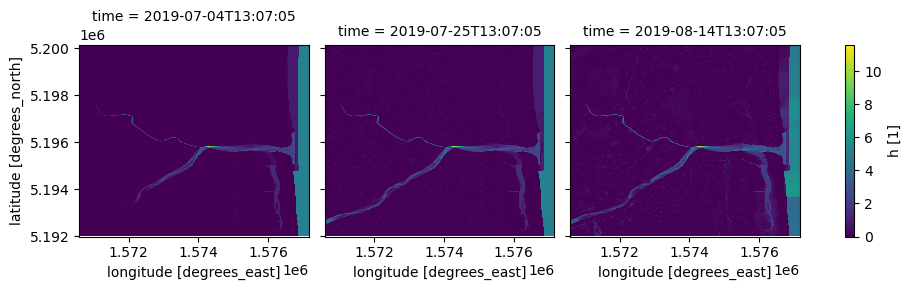

In [23]:
ds_plot = ds.h.isel(time=[0,21,41])
ds_plot.where(ds_plot!=-999).plot(col="time")

In [21]:
import numpy
from osgeo import gdal        
    
raster1 = f'{base_path}/datasets/dt_1.tif'
raster2 = f'{base_path}/assemble/dt_flood/2019/07/05/dt_flood_2019-07-05_h.tif'

ds1 = gdal.Open(raster1)
ds2 = gdal.Open(raster2)

r1 = numpy.array(ds1.ReadAsArray())
r2 = numpy.array(ds2.ReadAsArray())

d = numpy.array_equal(r1,r2)

if d == False:
    print("They differ")

else:
    print("They are the same")

They are the same


In [22]:
r1

array([[7.8021165e-04, 7.8080350e-04, 1.6156246e-04, ..., 5.0016704e+00,
        5.0016704e+00, 5.0016704e+00],
       [7.7848288e-04, 7.7907130e-04, 1.6141070e-04, ..., 5.0016704e+00,
        5.0016704e+00, 5.0016704e+00],
       [2.8594382e-04, 2.8708766e-04, 1.0725366e-04, ..., 5.0016704e+00,
        5.0016704e+00, 5.0016704e+00],
       ...,
       [4.7129398e-04, 4.7045105e-04, 1.7254890e-03, ..., 5.0016775e+00,
        5.0016775e+00, 5.0016775e+00],
       [4.7129398e-04, 4.7045105e-04, 1.7254890e-03, ..., 5.0016775e+00,
        5.0016775e+00, 5.0016775e+00],
       [4.7129398e-04, 4.7045105e-04, 1.7254890e-03, ..., 5.0016775e+00,
        5.0016775e+00, 5.0016775e+00]], dtype=float32)

In [23]:
r2

array([[7.8021165e-04, 7.8080350e-04, 1.6156246e-04, ..., 5.0016704e+00,
        5.0016704e+00, 5.0016704e+00],
       [7.7848288e-04, 7.7907130e-04, 1.6141070e-04, ..., 5.0016704e+00,
        5.0016704e+00, 5.0016704e+00],
       [2.8594382e-04, 2.8708766e-04, 1.0725366e-04, ..., 5.0016704e+00,
        5.0016704e+00, 5.0016704e+00],
       ...,
       [4.7129398e-04, 4.7045105e-04, 1.7254890e-03, ..., 5.0016775e+00,
        5.0016775e+00, 5.0016775e+00],
       [4.7129398e-04, 4.7045105e-04, 1.7254890e-03, ..., 5.0016775e+00,
        5.0016775e+00, 5.0016775e+00],
       [4.7129398e-04, 4.7045105e-04, 1.7254890e-03, ..., 5.0016775e+00,
        5.0016775e+00, 5.0016775e+00]], dtype=float32)